In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import csv
import warnings
from scipy.interpolate import CubicSpline

In [2]:
warnings.filterwarnings("ignore")

In [3]:
def plot_columns(df):
    colors = plt.cm.tab20(range(df.shape[1]))  

    for i, column in enumerate(df.columns):
        color = colors[i % 24]

        plt.figure()
        plt.plot(df.index, df[column], color=color)
        plt.xlabel('Ano')
        plt.ylabel('Valor')
        plt.title(column)

    plt.show()

In [4]:
def centered_moving_average(column, window_action, window_size):
    start_index, end_index = window_action
    data = column.to_numpy()

    data_length = len(data)

    for i in range(start_index, end_index + 1):
        if not np.isnan(data[i]):
            init = data[i]
            start = max(0, i - window_size)
            end = min(data_length, i + window_size + 1)
            window = data[start:end]
            valid_values = [value for value in window if not pd.isna(value)]
            if len(valid_values) > 0:
                data[i] = np.mean(valid_values)

    modified_column = pd.Series(data, name=column.name)

    return modified_column

In [5]:
# Cubic spline Interpolation data inputation method
def four_ends_filler(column):
    if  pd.api.types.is_numeric_dtype(column):
        for i in range(4):
            column = first_filler(column, i, len(column) - 1 - i)
            column = last_filler(column, i, len(column) - 1 - i)
    return column

def four_ends_linear_filler(column):
    if  pd.api.types.is_numeric_dtype(column):
        size = len(column) - 1
        column = first_filler(column, 0, size)
        column = last_filler(column, 0, size)
        for i in range(1, 4):
            value = column.at[i]
            if (pd.isnull(value) or np.isnan(value) or (value == '')):
                start_first = i - 1
                end_first = next_valid_index(column, i)
                linear_a = (column.at[end_first] - column.at[i - 1])/(end_first - start_first)
                linear_b = column.at[start_first] - linear_a*start_first
                column.at[i] = linear_a*i + linear_b
            x = size - 4 + i
            value = column.at[x]
            if (pd.isnull(value) or np.isnan(value) or (value == '')):
                start_last = prev_valid_index(column, x)
                end_last = next_valid_index(column, x)
                gap = list(range(start_last + 1, end_last))
                linear_a = (column.at[end_last] - column.at[start_last])/(end_last - start_last)
                linear_b = column.at[start_last] - linear_a*start_last
                column.at[x] = linear_a*x + linear_b
    return column

def first_filler(column, init, end):
    if pd.isnull(column.at[init]) or np.isnan(column.at[init]):
        first_valid_index = 0
        while first_valid_index <= end and (pd.isnull(column.at[first_valid_index]) or 
                                             np.isnan(column.at[first_valid_index])):
            first_valid_index += 1
        if first_valid_index > end:
            column.at[init] = 0.0
        else:
            column.at[init] = column.at[first_valid_index]
    return column
    
def last_filler(column, init, end):
    if pd.isnull(column.at[end]) or np.isnan(column.at[end]):
        last_valid_index = len(column) -1
        while last_valid_index >= init and (pd.isnull(column.at[last_valid_index]) or 
                                         np.isnan(column.at[last_valid_index])):
            last_valid_index -= 1
        if last_valid_index < init:
            column.at[end] = 0.0
        else:
            column.at[end] = column.at[last_valid_index]
    return column
  
def neareast_four_indexes(column, start, end):
    return prev_four_valid_indexes(column, start) + next_four_valid_indexes(column, end)

def prev_four_valid_indexes(column, pos):
    prev_index = pos
    index_prev_list = [0]*4
    size = len(column) - 1
    if pos > 0 and pos < size:
        for i in range(4):
            index_prev_list[3 - i] = prev_index
            prev_index -= 1
            while prev_index >= 0 and (pd.isnull(column.at[prev_index]) or np.isnan(column.at[prev_index])):
                prev_index -= 1
    return index_prev_list  

def next_four_valid_indexes(column, pos):
    next_index = pos
    index_next_list = [0]*4
    size = len(column) - 1
    if pos > 0 and pos < size:
        for i in range(4):
            index_next_list[i] = next_index
            next_index += 1
            while next_index <= size and (pd.isnull(column.at[next_index]) or np.isnan(column.at[next_index])):
                next_index += 1
    return index_next_list  

def prev_valid_index(column, pos):
    prev_index = pos
    size = len(column) -1
    if pos >= 0 and pos < size:
        prev_index -= 1
        while prev_index >= 0 and (pd.isnull(column.at[prev_index]) or np.isnan(column.at[prev_index])):
            prev_index -= 1
    return prev_index  

def next_valid_index(column, pos):
    next_index = pos
    size = len(column) -1
    if pos >= 0 and pos < size:
        next_index += 1
        while next_index <= size and (pd.isnull(column.at[next_index]) or np.isnan(column.at[next_index])):
            next_index += 1
    return next_index

def interpolating_polynomial(nearest_indexes, nearest_values):
    coeffs = np.polyfit(nearest_indexes, nearest_values, 3)
    return np.poly1d(coeffs)

def polynomial_filler(column):
    size = len(column) -1
    if column.isnull().any() and column.isna().any():
        for i, value in enumerate(column):
            if (i > 3 and i < size - 3) and (pd.isnull(value) or np.isnan(value) or (value == '')):
                nearest_values = []
                start = prev_valid_index(column, i)
                end = next_valid_index(column, i)
                gap = list(range(start + 1, end))
                nearest_indexes = neareast_four_indexes(column, start, end)
                for index in nearest_indexes:
                    nearest_values.append(column.at[index])
                polynomial = interpolating_polynomial(nearest_indexes, nearest_values)
                for x in gap:
                    column.at[x] = polynomial(x)
                plot_polynomial(polynomial, nearest_indexes[0], nearest_indexes[len(nearest_indexes) - 1], 50, gap, nearest_indexes, column.name)
    return column

def plot_polynomial(polynomial, start, end, precision, interpolated_list, nearest_indexes, column_name):
    x = np.linspace(start, end, precision)
    y = polynomial(x)

    plt.figure()

    plt.plot(x, y)

    interpolated_x = interpolated_list  
    interpolated_y = polynomial(interpolated_x)
    plt.scatter(interpolated_x, interpolated_y, color='red')
    interpolated_x = nearest_indexes  
    interpolated_y = polynomial(interpolated_x)
    plt.scatter(interpolated_x, interpolated_y, color='green')
    
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title(column_name)

    plt.show()
    
def replace_negative_with_float_zeros(x):
    return 0.0 if x < 0 else x

In [6]:
def read_csv_replace_missing_by_polynomial(file_path, skiped_rows, skiped_columns):
    with open(file_path, 'r') as f:
        
        df = pd.read_csv(file_path, skiprows=skiped_rows)
        
        i = 0
        for col in df.columns: # Elimina missing values por médias e transforma em float
            if i > skiped_columns:
                df[col] = df[col].replace('-9999', np.nan)
                df[col] = df[col].replace('-', np.nan)
                df[col] = df[col].replace('', np.nan).astype(float)
                df[col] = four_ends_linear_filler(df[col])
                df[col] = centered_moving_average(df[col], (0, len(df[col]) - 1), 24) #2 anos
                df[col] = polynomial_filler(df[col])
            i += 1
        return df

In [7]:
df = read_csv_replace_missing_by_polynomial('rio_grande_do_sul_variacao_climatica.csv', 0, 1)
df.rename(columns={'Date': 'Ano'}, inplace=True)
df['Ano'] = df['Ano'].str[:4].astype(int)
df.drop(columns='State', inplace=True)
df.drop(columns='Year', inplace=True)
df.head(len(df))

,Ano,Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s)
0,2001,2.002044,1009.597309,1139.514129,20.635431,15.650124,74.972223,1.750008
1,2001,1.992462,1009.594102,1143.827976,20.596734,15.630157,75.047961,1.730048
2,2001,1.993022,1009.682736,1146.077429,20.515750,15.539042,74.997158,1.717135
3,2001,1.897486,1009.795066,1137.489000,20.355650,15.344842,74.848011,1.716881
4,2001,1.858941,1009.836087,1135.449639,20.236155,15.181813,74.617507,1.725950
...,...,...,...,...,...,...,...,...
259,2022,1.751181,1009.954932,1241.885892,19.604402,14.778259,75.897757,1.514329
260,2022,1.763594,1009.809917,1251.813117,19.753303,14.895047,75.777327,1.520209
261,2022,1.776990,1009.709861,1253.896301,19.867935,14.997385,75.759447,1.519289
262,2022,1.780996,1009.728429,1254.590021,19.897658,15.022762,75.748947,1.513904


In [8]:
df_year = df.copy()
df_year.set_index('Ano', inplace=True)
df_year = df_year.groupby('Ano').mean()
df_year['Precipitation (mm/day)'] = df_year['Precipitation (mm/day)'] * 12
df_year

,Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s)
Ano,,,,,,,
2001,22.834301,1009.820555,1146.085621,20.286929,15.209733,74.545903,1.721775
2002,22.098458,1010.117516,1173.657035,20.017984,14.784621,73.870969,1.699947
2003,20.534784,1010.304652,1196.072606,19.914822,14.560522,73.424505,1.689576
2004,19.331964,1010.323155,1192.773948,19.906476,14.560061,73.472109,1.648349
2005,19.728565,1010.259871,1185.484048,19.882045,14.607303,73.731114,1.630458
2006,20.254598,1010.152487,1181.629318,19.752756,14.544771,74.009463,1.631146
2007,20.801125,1009.972382,1177.246947,19.549931,14.420724,74.316933,1.628793
2008,21.764081,1009.667623,1159.549843,19.539269,14.577965,75.001024,1.589194
2009,22.056812,1009.481089,1148.622979,19.521903,14.707061,75.640304,1.544445


In [10]:
df_2014 = df_year[df_year.index >= 2014]
df_2014

,Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s)
Ano,,,,,,,
2014,24.400941,1009.762470,1171.719265,20.146399,15.684750,77.480667,1.400940
2015,24.916446,1009.840981,1172.307462,20.091834,15.811951,78.312245,1.426194
2016,25.386577,1009.893214,1192.750068,20.140420,15.954377,78.787281,1.473465
2017,24.738710,1009.894951,1193.749290,20.268929,16.171905,79.268644,1.530121
2018,23.648255,1009.911820,1214.031218,20.305281,15.913403,78.031657,1.536947
2019,23.466402,1009.855691,1229.609833,20.190995,15.454018,76.451139,1.522285
2020,23.285394,1009.780913,1224.000510,19.997565,15.220978,76.170814,1.508890
2021,22.176346,1009.813296,1222.668932,19.756771,14.981937,76.152649,1.497501
2022,21.226064,1009.891367,1221.986125,19.586118,14.831296,76.218239,1.497819


In [11]:
df_2014.to_csv('2014_01_meteo.csv', index=True)

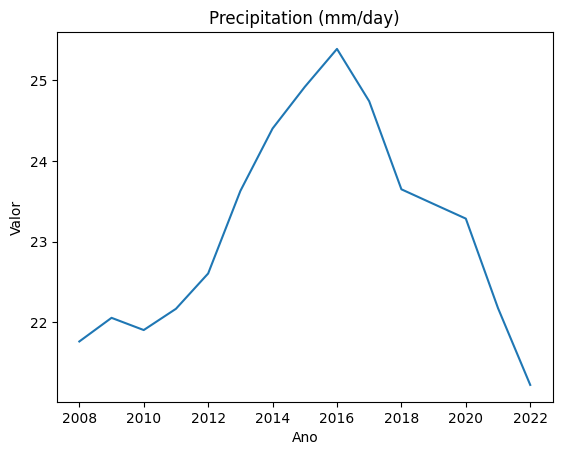

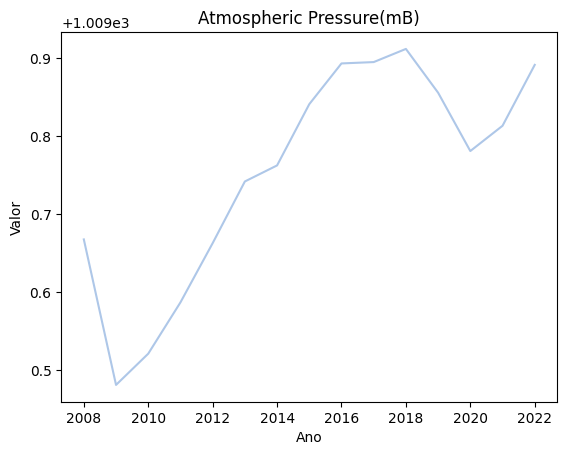

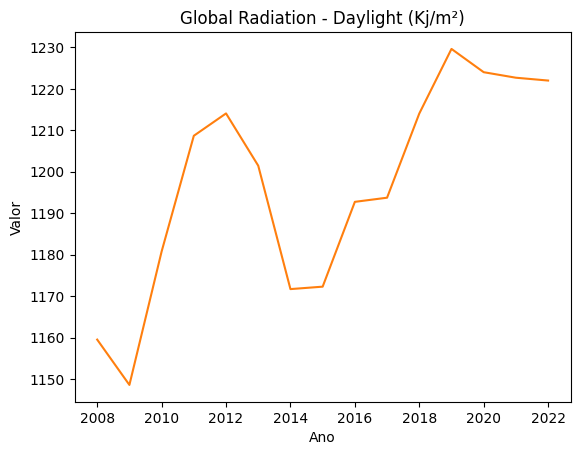

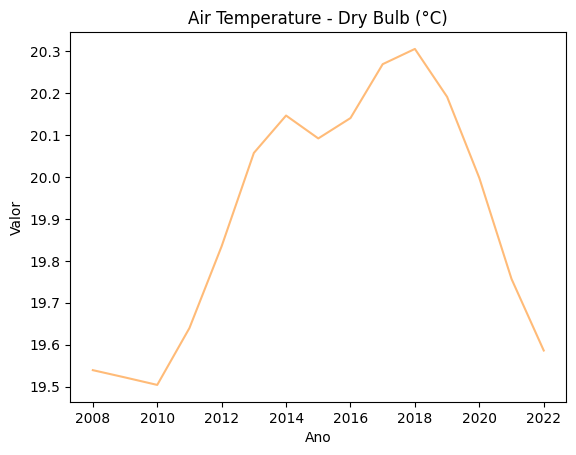

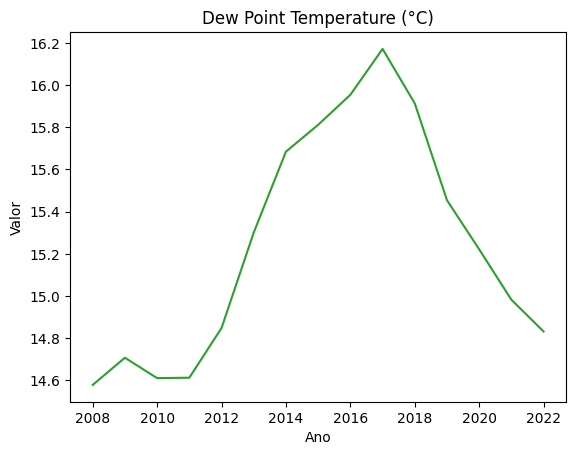

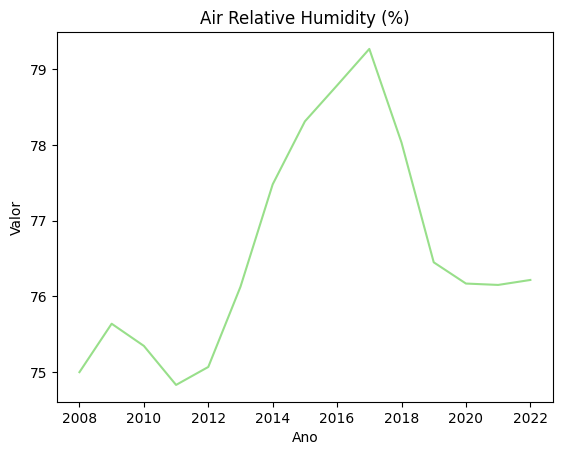

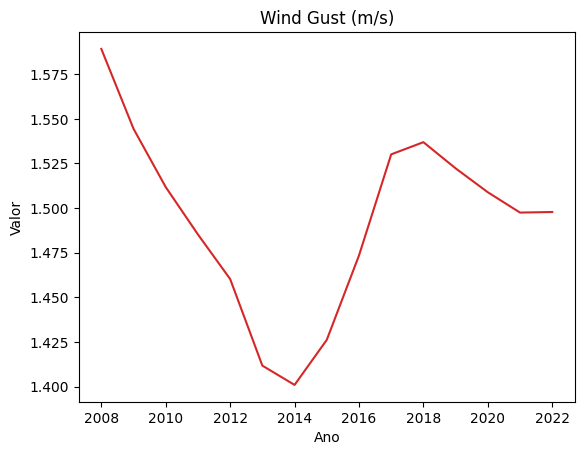

,Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s)
Ano,,,,,,,
2008,21.764081,1009.667623,1159.549843,19.539269,14.577965,75.001024,1.589194
2009,22.056812,1009.481089,1148.622979,19.521903,14.707061,75.640304,1.544445
2010,21.905564,1009.521141,1180.776262,19.504051,14.610253,75.347633,1.511781
2011,22.168556,1009.586912,1208.677123,19.639685,14.612190,74.832405,1.485231
2012,22.605974,1009.662812,1214.063067,19.834806,14.847869,75.069595,1.460267
2013,23.627714,1009.741901,1201.461810,20.057230,15.300827,76.128780,1.411746
2014,24.400941,1009.762470,1171.719265,20.146399,15.684750,77.480667,1.400940
2015,24.916446,1009.840981,1172.307462,20.091834,15.811951,78.312245,1.426194
2016,25.386577,1009.893214,1192.750068,20.140420,15.954377,78.787281,1.473465


In [12]:
df_2008 = df_year[df_year.index >= 2008]
plot_columns(df_2008)
df_2008

In [13]:
df_2008.to_csv('2008_01_meteo.csv', index=True)